# Mask detection CNN training

In [1]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("train"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 5 directories and 0 images in 'train'.
There are 0 directories and 850 images in 'train\Correct'.
There are 0 directories and 850 images in 'train\Mask_Chin'.
There are 0 directories and 849 images in 'train\Mask_Mouth_Chin'.
There are 0 directories and 522 images in 'train\Mask_Nose_Mouth'.
There are 0 directories and 827 images in 'train\Without_Mask'.


In [2]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("test"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 5 directories and 0 images in 'test'.
There are 0 directories and 150 images in 'test\Correct'.
There are 0 directories and 150 images in 'test\Mask_Chin'.
There are 0 directories and 150 images in 'test\Mask_Mouth_Chin'.
There are 0 directories and 93 images in 'test\Mask_Nose_Mouth'.
There are 0 directories and 139 images in 'test\Without_Mask'.


In [3]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path("train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['Correct' 'Mask_Chin' 'Mask_Mouth_Chin' 'Mask_Nose_Mouth' 'Without_Mask']


In [4]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (726, 726)


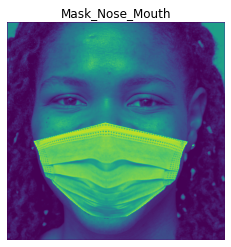

In [5]:
# View a random image from the training dataset
img = view_random_image(target_dir="train/",
                        target_class="Mask_Nose_Mouth")

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "train/"
test_dir = "test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="categorical", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)

# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)


Found 3898 images belonging to 5 classes.
Found 682 images belonging to 5 classes.


In [7]:
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(224, 224,3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(5, activation="softmax") # activation output
])

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
122/122 [==============================] - 143s 1s/step - loss: 0.5488 - accuracy: 0.8094 - val_loss: 0.1403 - val_accuracy: 0.9516
Epoch 2/5
122/122 [==============================] - 148s 1s/step - loss: 0.0707 - accuracy: 0.9767 - val_loss: 0.1416 - val_accuracy: 0.9531
Epoch 3/5
122/122 [==============================] - 143s 1s/step - loss: 0.0300 - accuracy: 0.9920 - val_loss: 0.1514 - val_accuracy: 0.9545
Epoch 4/5
122/122 [==============================] - 149s 1s/step - loss: 0.0196 - accuracy: 0.9936 - val_loss: 0.1067 - val_accuracy: 0.9663
Epoch 5/5
122/122 [==============================] - 150s 1s/step - loss: 0.0053 - accuracy: 0.9990 - val_loss: 0.0990 - val_accuracy: 0.9736


## Data augmentation

In [8]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("vertical"), # randomly flip images
  preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  preprocessing.RandomZoom(0.2), # randomly zoom into an image
  # preprocessing.Rescaling(255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

## Transfer learning 1

In [9]:
len(class_names)

5

In [10]:
# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
# train_datagen = ImageDataGenerator(rescale=1./255)
# valid_datagen = ImageDataGenerator(rescale=1./255)

train_datagen = ImageDataGenerator()
valid_datagen = ImageDataGenerator()

# Setup the train and test directories
train_dir = "train/"
test_dir = "test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="categorical", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)

Found 3898 images belonging to 5 classes.
Found 682 images belonging to 5 classes.


In [11]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
# x=inputs
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model2 = tf.keras.Model(inputs, outputs)

In [12]:
# Compile
model2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_model2 = model2.fit(train_data,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=valid_data,
                                           validation_steps=int(len(valid_data)))

Epoch 1/5
122/122 [==============================] - 238s 2s/step - loss: 0.6895 - accuracy: 0.7953 - val_loss: 0.4205 - val_accuracy: 0.8827
Epoch 2/5
122/122 [==============================] - 278s 2s/step - loss: 0.3228 - accuracy: 0.9153 - val_loss: 0.3169 - val_accuracy: 0.9003
Epoch 3/5
122/122 [==============================] - 243s 2s/step - loss: 0.2522 - accuracy: 0.9346 - val_loss: 0.3113 - val_accuracy: 0.8944
Epoch 4/5
122/122 [==============================] - 237s 2s/step - loss: 0.2083 - accuracy: 0.9420 - val_loss: 0.2498 - val_accuracy: 0.9238
Epoch 5/5
122/122 [==============================] - 220s 2s/step - loss: 0.1879 - accuracy: 0.9459 - val_loss: 0.2561 - val_accuracy: 0.9135


In [15]:
initial_epoch=5

base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

In [17]:
history3=model2.fit(train_data,
            epochs=initial_epoch +5,
            validation_data=valid_data,
            initial_epoch=initial_epoch)

Epoch 6/9
122/122 [==============================] - 283s 2s/step - loss: 0.1264 - accuracy: 0.9554 - val_loss: 0.2000 - val_accuracy: 0.9311
Epoch 7/9
122/122 [==============================] - 232s 2s/step - loss: 0.0937 - accuracy: 0.9674 - val_loss: 0.1617 - val_accuracy: 0.9501
Epoch 8/9
122/122 [==============================] - 287s 2s/step - loss: 0.0737 - accuracy: 0.9741 - val_loss: 0.1557 - val_accuracy: 0.9560
Epoch 9/9
122/122 [==============================] - 238s 2s/step - loss: 0.0639 - accuracy: 0.9790 - val_loss: 0.1694 - val_accuracy: 0.9472


In [19]:
model_1.save("model1.h5")
model2.save("model2.h5")

C:\Users\38068\.conda\envs\tutorialspoint\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
